# 1. Import 

In [1]:
# stardist / tensorflow env variables setup
import os
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import copy
from pathlib import Path
import pandas as pd

import numpy as np
import napari
from napari.utils.notebook_display import nbscreenshot
from tqdm import tqdm
from rich.pretty import pprint

from stardist.models import StarDist2D

from ultrack import track, to_tracks_layer, tracks_to_zarr
from ultrack.imgproc import normalize
from ultrack.imgproc.segmentation import Cellpose
from ultrack.utils import estimate_parameters_from_labels, labels_to_edges
from ultrack.utils.array import array_apply
from ultrack.config import MainConfig

2024-05-17 10:53:44.823442: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-17 10:53:44.823509: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-17 10:53:44.890917: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-17 10:53:45.028334: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-17 10:53:46.340970: W tensorflow/compiler/tf2

# 2. Load films and compute cell detection and boundaries

## 2.1 Load and visualize movie

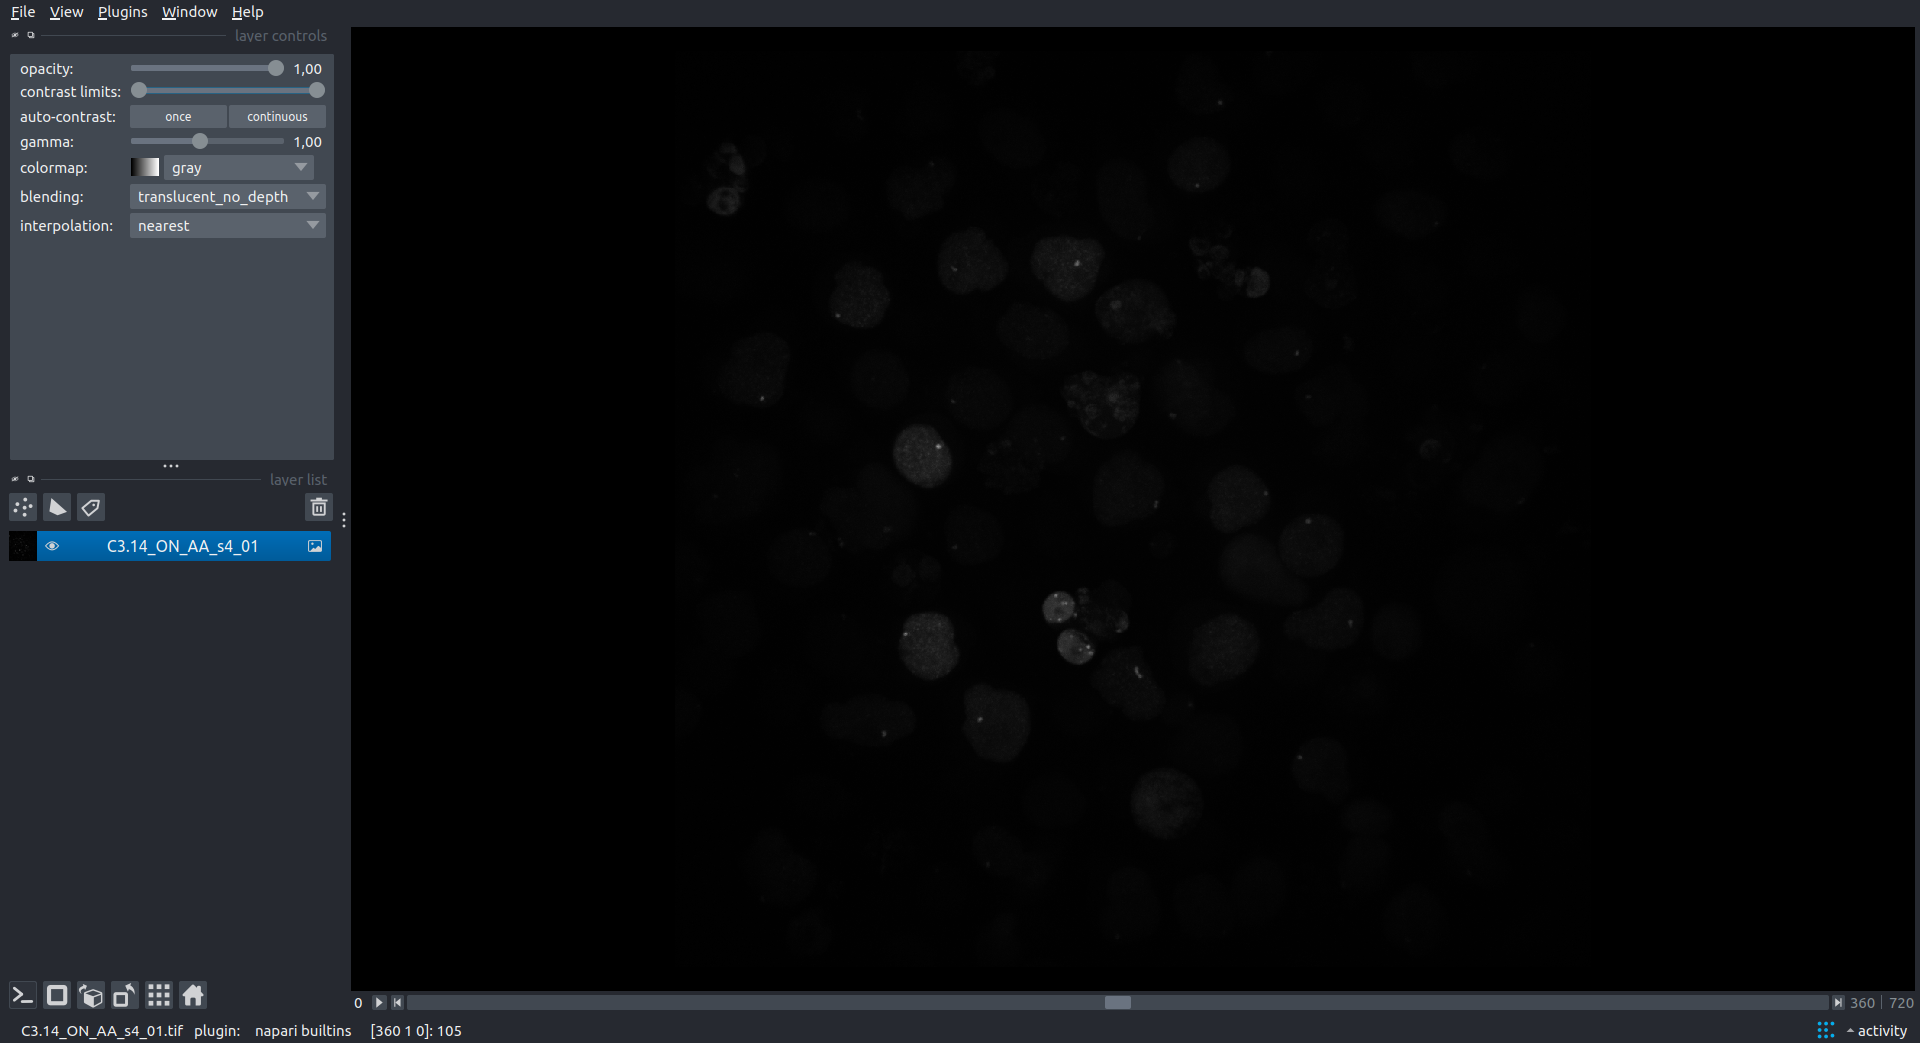

In [2]:
dataset_path = Path("/media/raphael/data/works/20231220_C3_14_2h_ofON")

viewer = napari.Viewer()
viewer.window.resize(1800, 1000)
viewer.open(sorted(dataset_path.glob("C3.14_ON_AA_s4_01.tif")), stack=True)

image = viewer.layers[0].data

nbscreenshot(viewer)

## 2.2 Segmentation using cellpose

In [3]:
cellpose = Cellpose(model_type="cyto", gpu=False)

def predict(frame, gamma):
    norm_frame = normalize(np.asarray(frame), gamma=gamma)
    return cellpose(norm_frame, tile=False, normalize=False, diameter=100)

cellpose_labels = np.zeros(image.shape, dtype=np.int32)
array_apply(image, 
            out_array=cellpose_labels, 
            func=predict,
            gamma=0.5
           )

viewer.add_labels(cellpose_labels, name="cellpose")
    

Applying predict ...: 100%|█████████████████| 721/721 [2:35:12<00:00, 12.92s/it]


<Labels layer 'cellpose' at 0x7f73c819b9d0>

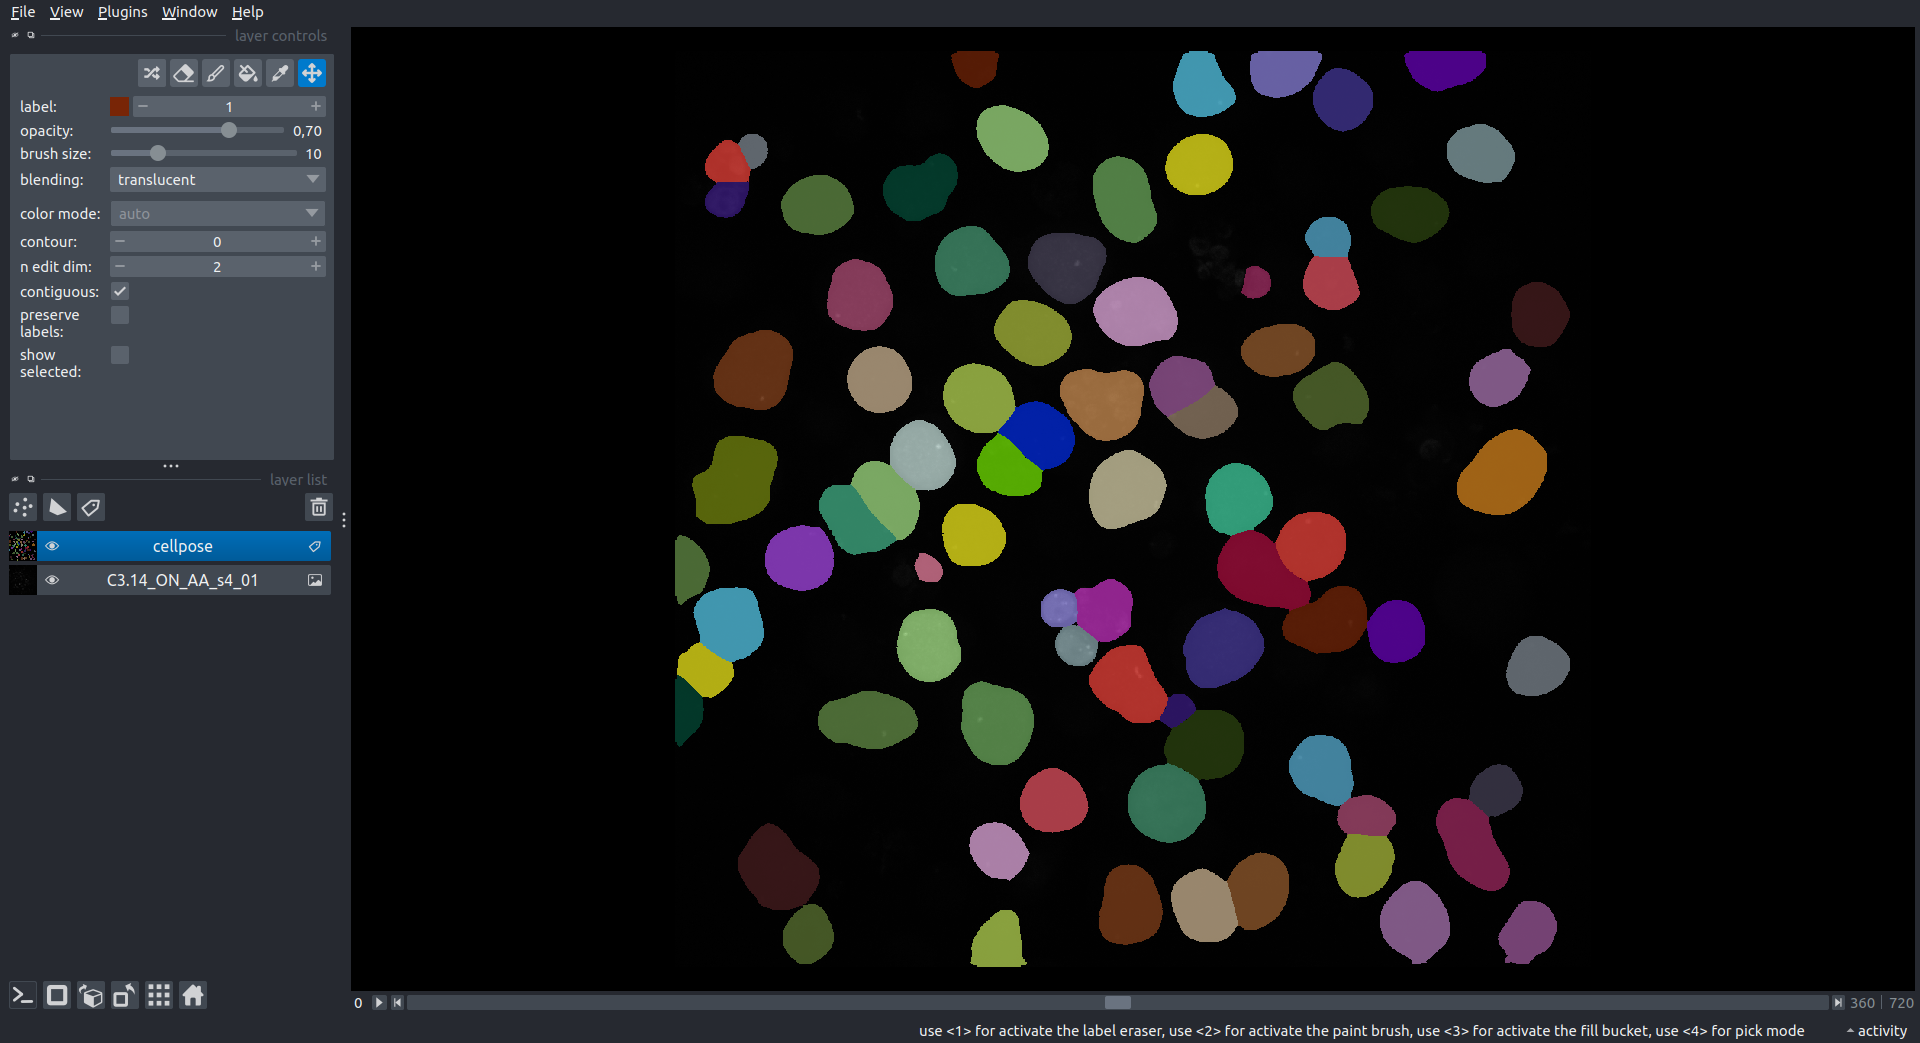

In [4]:
nbscreenshot(viewer)

In [5]:
detection, edges = labels_to_edges(cellpose_labels, sigma=4.0)  # multiple labels can be used with [labels_0, labels_1, ...]

Converting labels to edges: 100%|█████████████| 721/721 [01:29<00:00,  8.09it/s]


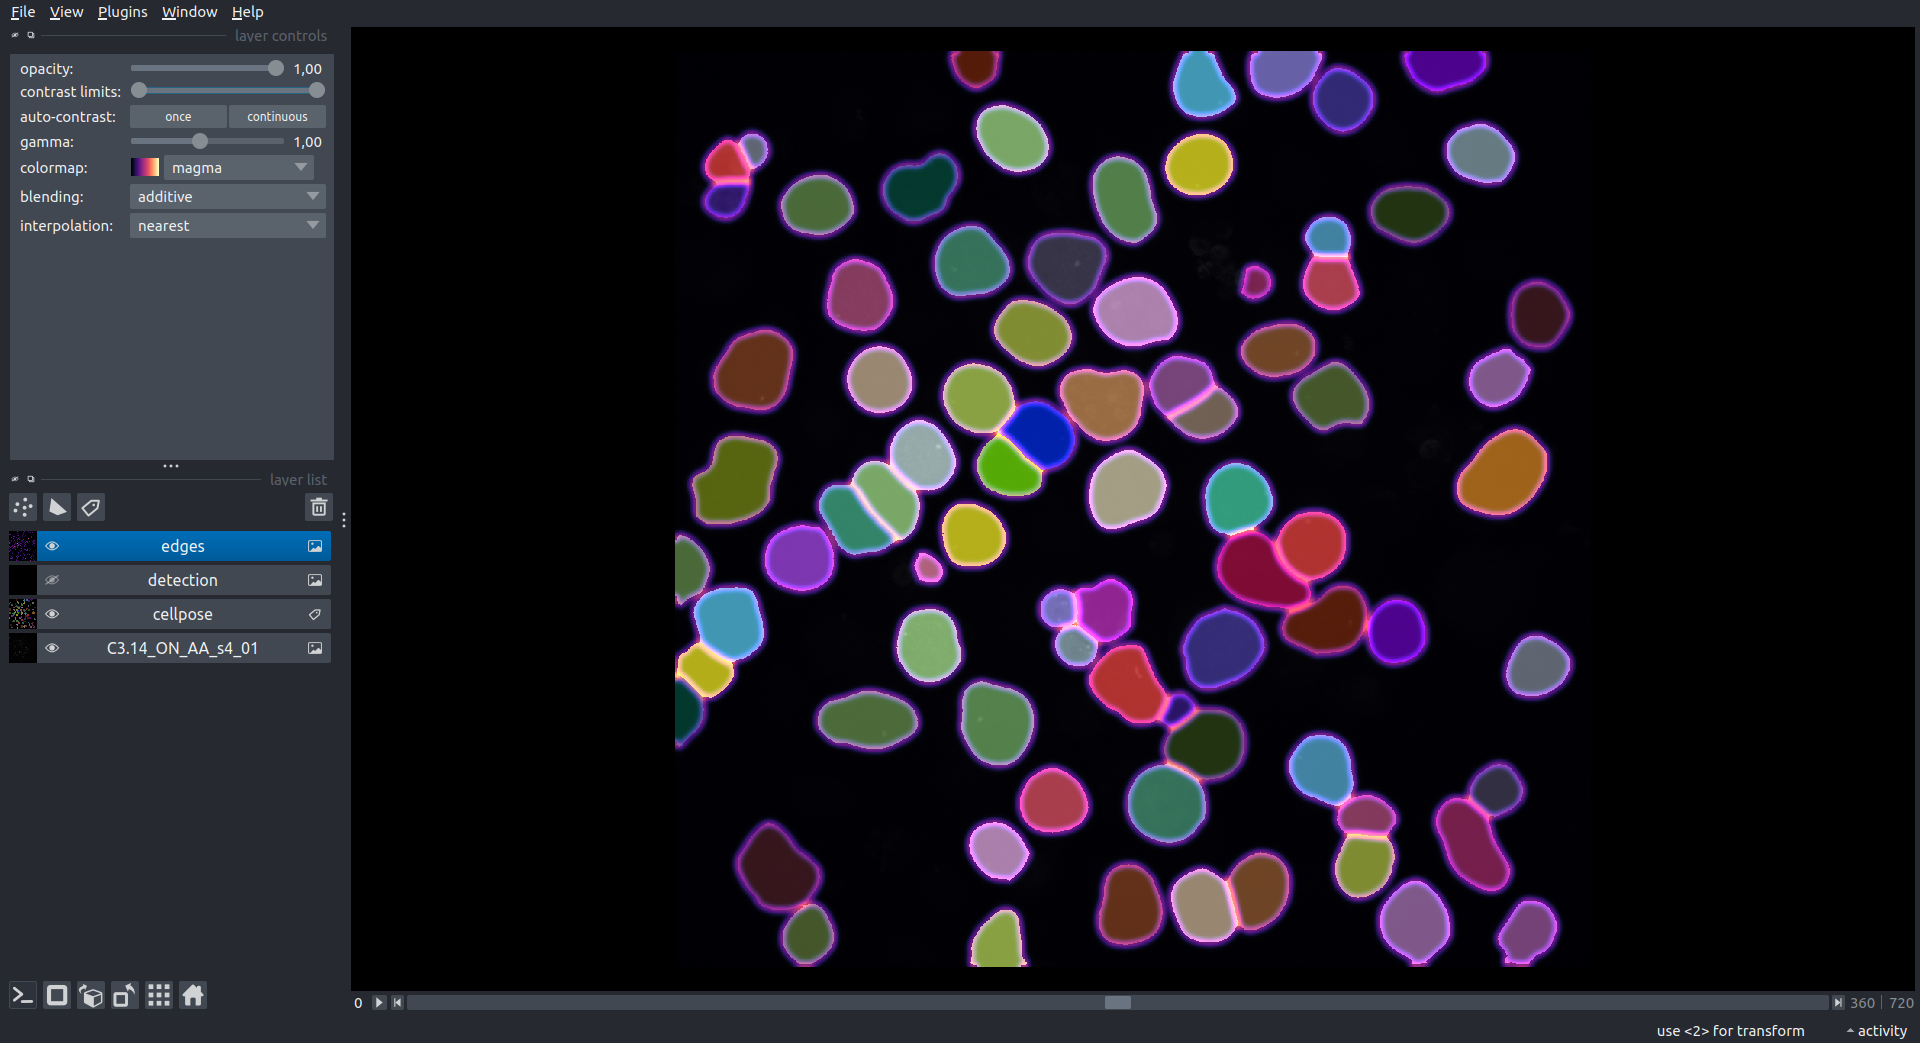

In [6]:
viewer.add_image(detection, visible=False)
viewer.add_image(edges, blending="additive", colormap="magma")
nbscreenshot(viewer)

## 2.3 Save segmentation results 
In case tracking is impossible 

In [8]:
from correct_cells import * 

In [9]:
save_layers(cellpose_labels,'C3.14_ON_AA_s4_01_cellpose')
save_layers(detection, 'C3.14_ON_AA_s4_01_detection')
save_layers(edges, 'C3.14_ON_AA_s4_01_edges')

Saving frame |████████████████████████████████████████| 721/721 [100%] in 2:08.4
Saving frame |████████████████████████████████████████| 721/721 [100%] in 1:56.5
Saving frame |████████████████████████████████████████| 721/721 [100%] in 7:41.8


# 3. Tracking 

In [7]:
config = MainConfig()
pprint(config)

MainConfig(
│   data_config=DataConfig(working_dir=PosixPath('.'), database='sqlite', address=None, n_workers=1),
│   segmentation_config=SegmentationConfig(
│   │   threshold=0.5,
│   │   min_area=100,
│   │   max_area=1000000,
│   │   min_frontier=0.0,
│   │   anisotropy_penalization=0.0,
│   │   max_noise=0.0,
│   │   ws_hierarchy=<function watershed_hierarchy_by_area at 0x7f6af5b0ab90>,
│   │   n_workers=1
│   ),
│   linking_config=LinkingConfig(
│   │   n_workers=1,
│   │   max_neighbors=5,
│   │   max_distance=15.0,
│   │   distance_weight=0.0,
│   │   z_score_threshold=5.0
│   ),
│   tracking_config=TrackingConfig(
│   │   appear_weight=-0.001,
│   │   disappear_weight=-0.001,
│   │   division_weight=-0.001,
│   │   dismiss_weight_guess=None,
│   │   include_weight_guess=None,
│   │   window_size=None,
│   │   overlap_size=1,
│   │   solution_gap=0.001,
│   │   time_limit=36000,
│   │   method=0,
│   │   n_threads=-1,
│   │   link_function='power',
│   │   power=4,
│   │   bias=-0.0
│   )
)

Estimating params.: 100%|███████████████████████| 10/10 [00:00<00:00, 33.01it/s]


<Axes: title={'center': 'Area histogram'}, ylabel='Frequency'>

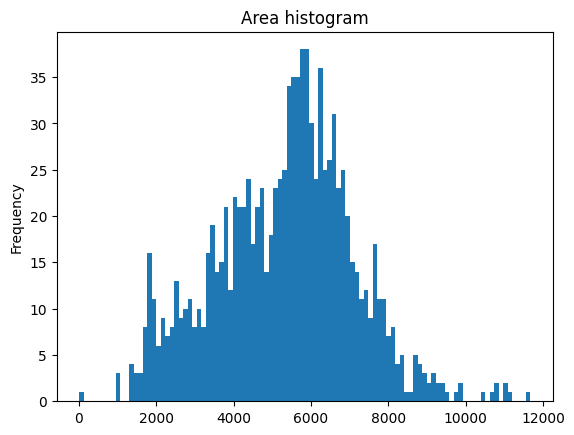

In [8]:
params_df = estimate_parameters_from_labels(cellpose_labels, is_timelapse=True)
params_df["area"].plot(kind="hist", bins=100, title="Area histogram")

Need to adjust the min and max area according to the histogram 

In [9]:
config.segmentation_config.min_area = 500
config.segmentation_config.max_area = 8000
config.segmentation_config.n_workers = 8

In [10]:
config.linking_config.max_distance = 50 #maximum spatial distance between cells
config.linking_config.n_workers = 8

config.tracking_config.appear_weight = -1
config.tracking_config.disappear_weight = -1
config.tracking_config.division_weight = -0.1
config.tracking_config.power = 3
config.tracking_config.bias = -0.001
config.tracking_config.solution_gap = 0.0

pprint(config)

MainConfig(
│   data_config=DataConfig(working_dir=PosixPath('.'), database='sqlite', address=None, n_workers=1),
│   segmentation_config=SegmentationConfig(
│   │   threshold=0.5,
│   │   min_area=500,
│   │   max_area=8000,
│   │   min_frontier=0.0,
│   │   anisotropy_penalization=0.0,
│   │   max_noise=0.0,
│   │   ws_hierarchy=<function watershed_hierarchy_by_area at 0x7f6af5b0ab90>,
│   │   n_workers=8
│   ),
│   linking_config=LinkingConfig(
│   │   n_workers=8,
│   │   max_neighbors=5,
│   │   max_distance=50,
│   │   distance_weight=0.0,
│   │   z_score_threshold=5.0
│   ),
│   tracking_config=TrackingConfig(
│   │   appear_weight=-1,
│   │   disappear_weight=-1,
│   │   division_weight=-0.1,
│   │   dismiss_weight_guess=None,
│   │   include_weight_guess=None,
│   │   window_size=None,
│   │   overlap_size=1,
│   │   solution_gap=0.0,
│   │   time_limit=36000,
│   │   method=0,
│   │   n_threads=-1,
│   │   link_function='power',
│   │   power=3,
│   │   bias=-0.001
│   )
)

In [11]:
track(
    detection=detection,
    edges=edges,
    config=config,
    overwrite=True,
)

Linking nodes.: 100%|█████████████████████████████| 9/9 [00:09<00:00,  1.05s/it]


Using Coin-OR Branch and Cut solver
Solving ILP batch 0
Constructing ILP ...
Solving ILP ...
Welcome to the CBC MILP Solver 
Version: Trunk
Build Date: Oct 24 2021 

Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 3200 (-714) rows, 5252 (-896) columns and 9882 (-1730) elements
Clp1000I sum of infeasibilities 0,988927 - average 0,00030904, 2055 fixed columns
Coin0506I Presolve 1130 (-2070) rows, 1370 (-3882) columns and 3851 (-6031) elements
Clp0029I End of values pass after 1311 iterations
Clp0014I Perturbing problem by 0,001% of 1,0000001 - largest nonzero change 2,9547006e-05 ( 0,0014773503%) - largest zero change 2,9976734e-05
Clp0000I Optimal - objective value 186,6867
Clp0000I Optimal - objective value 186,6867
Coin0511I After Postsolve, objective 186,6867, infeasibilities - dual 5,4911478 (8), primal 0 (0)
Coin0512I Presolved model was optimal, full model needs cleaning up
Clp0014I Perturbing problem by 0,001% of 1 - largest

In [12]:
tracks_df, graph = to_tracks_layer(config)
labels = tracks_to_zarr(config, tracks_df)

Exporting segmentation masks: 100%|█████████████| 10/10 [00:00<00:00, 59.92it/s]


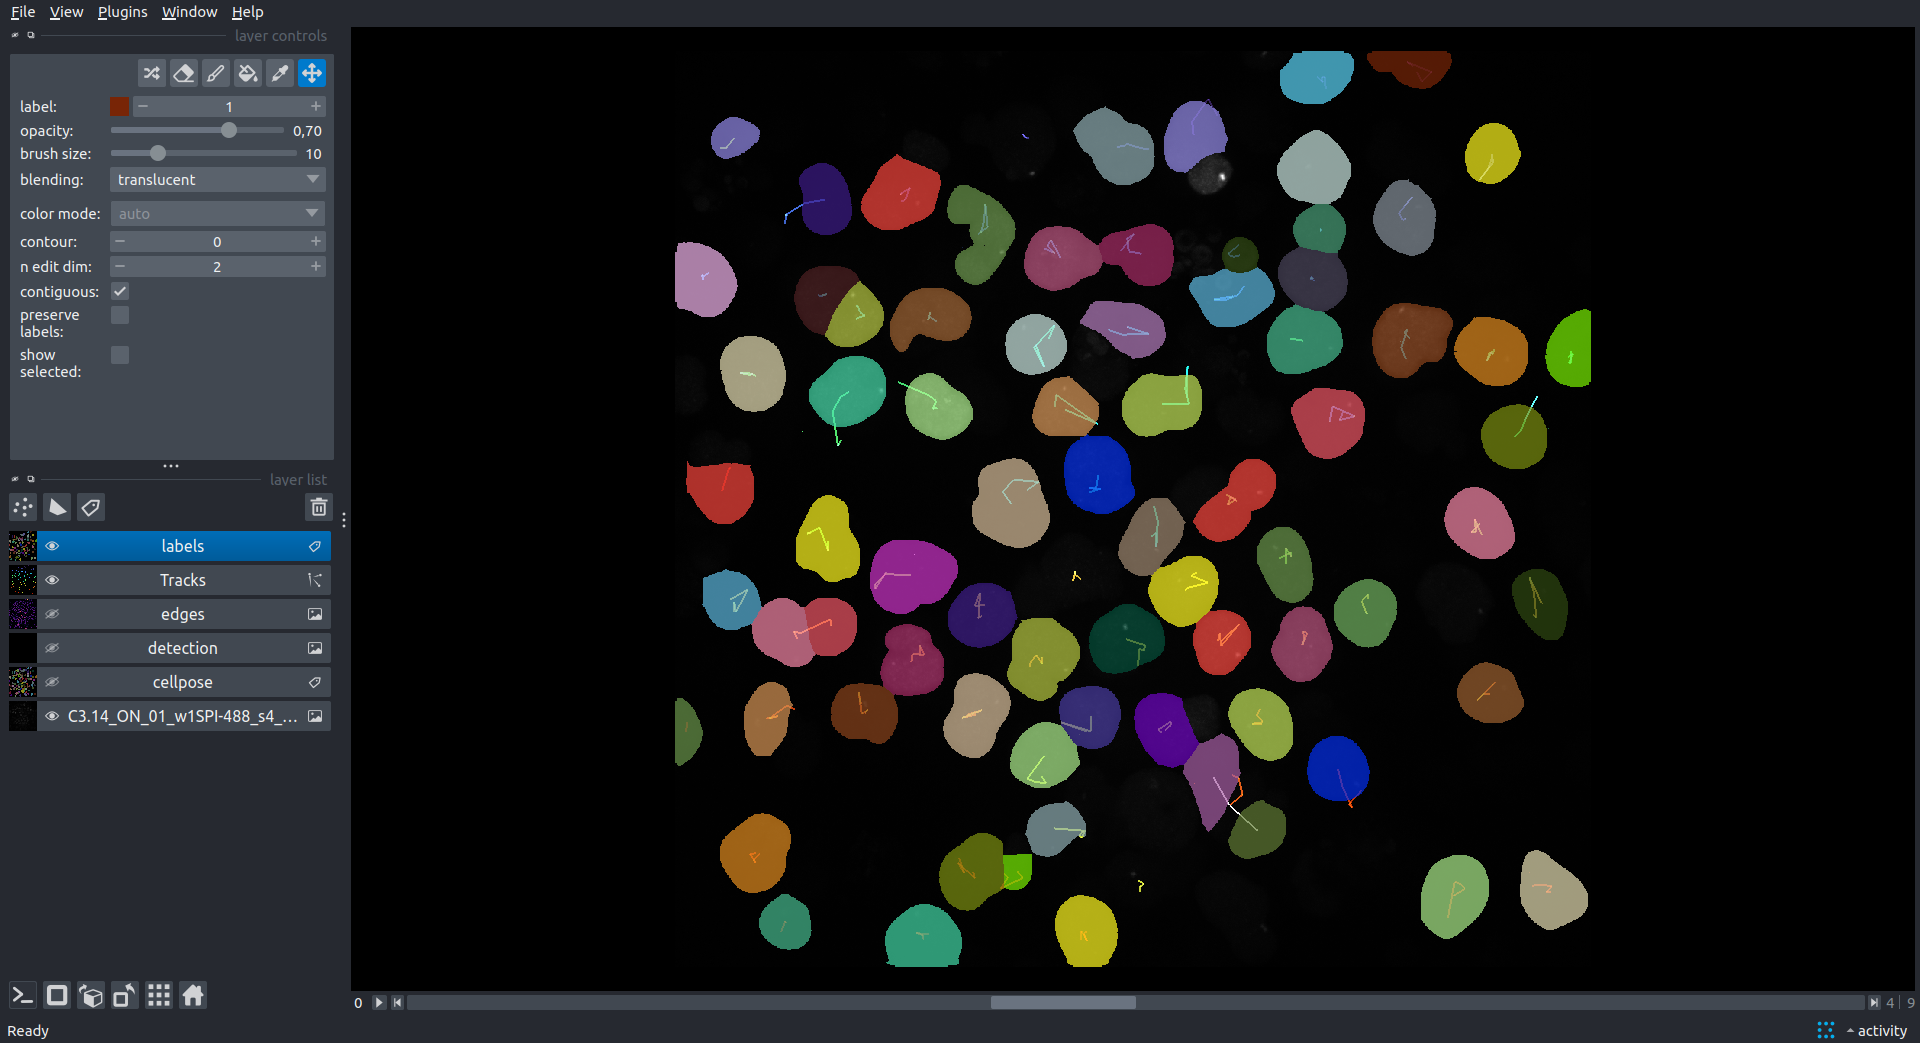

In [13]:
viewer.add_tracks(tracks_df[["track_id", "t", "y", "x"]].values, graph=graph)
viewer.add_labels(labels)

viewer.layers["cellpose"].visible = False
viewer.layers["edges"].visible = False

nbscreenshot(viewer)

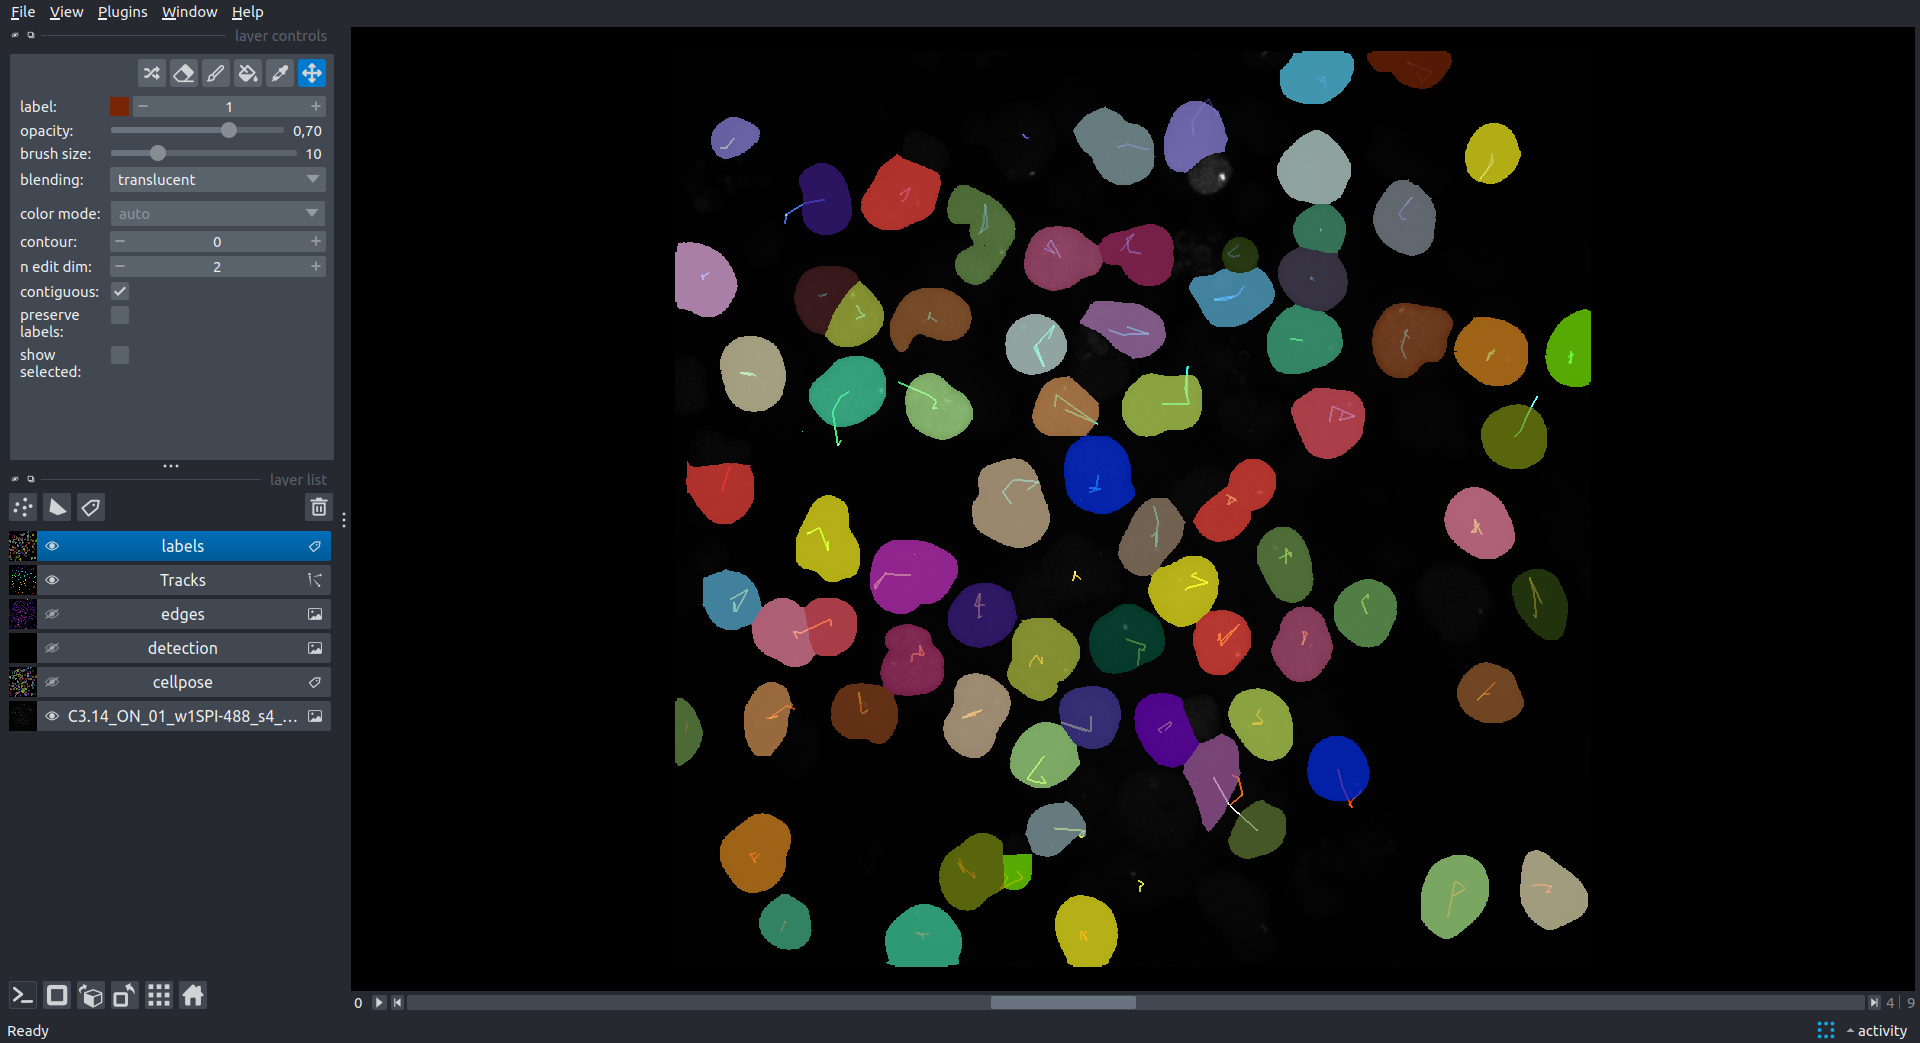

In [14]:
nbscreenshot(viewer)

# Correct cells 

In [15]:
Corrected_labels = copy.deepcopy(labels)

## get Number of cells 

In [16]:
def get_cells_number(labels):
    if not isinstance(labels, np.ndarray):
        #print(type(img))
        labels = labels[:]
        print("max number of cells : ", np.max(labels))

In [17]:
get_cells_number(Corrected_labels)

max number of cells :  97


## Automatically correct cells 

### Delete cells 

In [ ]:
def delete_cells(labels,cell):
    res = []
    if not isinstance(labels, np.ndarray):
        labels = labels[:]

    for label in labels:
        for y in range(0,label.shape[0]):
            for x in range (0,label.shape[1]):
                if label[y][x] == cell:
                    label[y][x]=0
        res.append(label)
    print("cell ",cell, "has been deleted on all frames")
    return res 
        


In [ ]:
d=() # tuple corresponding to the numbers of cell which will be deleted 
len_d = int(len(d))

In [ ]:
for i in range(0,len_d):
    print("cell to be deleted ", d[i])
    Corrected_labels = delete_cells(Corrected_labels, d[i])

### Merge neighboor cells 

In [18]:
def merge_neighboor_cells(parent_cell, child_cell,labels):
    '''
    The goal of this fonction is to merge neighboors cells where cellpose detect them as two when there is only one cell
    
    '''
    res=[]
    if not isinstance(labels, np.ndarray):
        labels = labels[:]
    
    for label in labels:
        for y in range (0, label.shape[0]):
            for x in range (0,label.shape[1]):
                if label[y][x] == child_cell:
                    label[y][x]=parent_cell
        res.append(label)
    print("Cell ", parent_cell, "has been joined to cell ", child_cell)
    return res



In [19]:
a=(29,30,91,92)

In [28]:
half_a = int(len(a))

In [29]:
for i in range(0,half_a,2):
    print("parent cell ", a[i]," child cell ",a[i+1])
    Corrected_labels = merge_neighboor_cells(a[i], a[i+1],Corrected_labels)

parent cell  29  child cell  30
Cell  29 has been joined to cell  30
parent cell  91  child cell  92
Cell  91 has been joined to cell  92


### Extend cells 

In [31]:
image_test = copy.deepcopy(image)

In [36]:
image_test=image_test.compute()

In [47]:
def extend_cells(image, Corrected_labels, cell,threshold):

    # peut etre utilisation de la recursivite pour corriger au pixel pres 
    ''' The goal of this fonction is to 
        browse images of cells and their masks 
        to extend the masks of the cell 
        using a threshold corresponding 
        to a ratio signal/noise on all frame 
    '''
    if not isinstance(image, np.ndarray):
        image = image.compute()

    if not isinstance(Corrected_labels, np.ndarray):
        Corrected_labels = Corrected_labels[:]

    for frame in image:
        for label in Corrected_labels:
            for y in range(0,frame.shape[0]):
                for x in range(0,frame.shape[1]):
                    if label[y][x] == cell:
                        print(frame[y][x])

                        if frame[y-1][x] > threshold : 
                            label[y-1][x] =cell
                            
                        elif frame[y][x-1] > threshold : 
                            label[y][x-1] =cell




In [ ]:
extend_cells(image_test, Corrected_labels, 10,150)

# 4. Save labels 

In [22]:
labels

<zarr.core.Array (10, 1200, 1200) int32>

In [23]:
import dask.array as da
import cv2  
import tifffile as tiff 
import napari
def save_zarr_images(img, folder, nameKey, imsQ,keyword, cellNumber=''):
    '''
    img : numpy or zarr core array of images 
    folder : directory where the file will be saved
    namekey : common pattern in the name of the images --> this will serve to give a name to the image saved 
    imsQ : common pattern in the name of the images (int)
    cellNumber : defaut = '' if the images correspond to a cell use the number of the cell here  
    keyword : keyword who will be add on the title of the saved file 
    '''
    extensionMov = ".tif"
    
    fullFolder = folder + "/" + keyword + "folder/"
    
    if not os.path.exists(fullFolder):
        os.makedirs(fullFolder)
            
    if not isinstance(img, np.ndarray):
        #print(type(img))
        img = img[:]
    
    for i in range(len(img)):  # No need for range(0, 10)
        filename =fullFolder+ nameKey + imsQ + "_" + keyword + "_" + str(cellNumber) + "_t" + f"{i+1:03}" + extensionMov
        try:
            tiff.imwrite(filename, img[i])
            print("Done for", filename)
        except Exception as e:
            print(f"Error saving {filename}: {e}")

In [24]:

savepath = "/media/raphael/data/works/20231220_C3_14_2h_ofON/10_movie_frame/test"
save_zarr_images(labels,savepath,"C3.14_ON_01_w1SPI-488_s","4","mask")

Done for /media/raphael/data/works/20231220_C3_14_2h_ofON/10_movie_frame/test/maskfolder/C3.14_ON_01_w1SPI-488_s4_mask__t001.tif
Done for /media/raphael/data/works/20231220_C3_14_2h_ofON/10_movie_frame/test/maskfolder/C3.14_ON_01_w1SPI-488_s4_mask__t002.tif
Done for /media/raphael/data/works/20231220_C3_14_2h_ofON/10_movie_frame/test/maskfolder/C3.14_ON_01_w1SPI-488_s4_mask__t003.tif
Done for /media/raphael/data/works/20231220_C3_14_2h_ofON/10_movie_frame/test/maskfolder/C3.14_ON_01_w1SPI-488_s4_mask__t004.tif
Done for /media/raphael/data/works/20231220_C3_14_2h_ofON/10_movie_frame/test/maskfolder/C3.14_ON_01_w1SPI-488_s4_mask__t005.tif
Done for /media/raphael/data/works/20231220_C3_14_2h_ofON/10_movie_frame/test/maskfolder/C3.14_ON_01_w1SPI-488_s4_mask__t006.tif
Done for /media/raphael/data/works/20231220_C3_14_2h_ofON/10_movie_frame/test/maskfolder/C3.14_ON_01_w1SPI-488_s4_mask__t007.tif
Done for /media/raphael/data/works/20231220_C3_14_2h_ofON/10_movie_frame/test/maskfolder/C3.14_ON